### Focus on Swiss Stocks:
- ABB (ABBN)
- Credit Suisse (CSGN)
- Nestle (NESN)
- Novartis (NOVN)

### The next goals are:
- Exploratory data analysis and stylized facts
- clean covariance matrices
- rolling window
- forecast LSTM


#### Stylized facts:
- Absence of linear autocorrelation
- Heavy-tailed returns
- Long memory of volatility
- outliers (threshold)

#### Plots:
- r_t vs time
- C (tao)
- log P>(r) vs r, if the tail is convex, P>(r) is heavy-tailed (1-ECDF(x)=RECDF(x)= P>(x) --> statsmodel)
- q-q plot of r vs Gaussian and exponential distribution
- plot C_|r|(tao) with log-log axes

 Implement a function that takes as input price returns and outputs the power-law exponent, 
 the starting point, the likelihood ratio of power-law vs exponential and power-law vs log-normal, 
 and if at all possible creates a pdf plot.

#### Correlation matrix cleaning

- We have very small N...
- rolling window length T
- clip eigenvalues


#### Strategies

- What exactly? 
- Measuring device


# Financial Big Data - Final Project

***Authors: Michael Allemann, Roman Bachmann***

In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from project_lib.preprocessing import preprocess
from project_lib.plotting import plot_1ecdf, plot_losses, plot_cumsums
from project_lib.dataset import StockDataSet
from project_lib.models import LSTM_Model

%matplotlib inline

In [2]:
# Device agnostic PyTorch setup
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    device = torch.device('cuda')
    torch.backends.cudnn.enabled = True
else:
    device = torch.device('cpu')
    torch.backends.cudnn.enabled = False

## 1 Data preprocessing

In [3]:
CWD = os.getcwd()
DATA_RAW_DIR = os.path.join(CWD, 'data/Raw/')
DATA_CLEAN_DIR = os.path.join(CWD, 'data/Clean/')

### 1.1 Cleaning data and computing log-returns

**Warning:** The following cells take a long time (1+h) to run. If data was already cleaned, it can be loaded directly below.

We load the stocks ABBN, CSGN, NESN and NOVN from the provided compressed files. To run the below code, place the Raw data folder under ```./data/Raw/<stock_name>/```.

From the raw files we compute the average best offer as $\frac{bid + ask}{2}$. We correctly set the time zone and resample such that we have five hourly data points from 11:00 to 15:00 every day. From this we then calculate log-returns.

In [ ]:
stocks_s = ['ABBN.S', 'CSGN.S', 'NESN.S', 'NOVN.S']
cleaned_df_s = preprocess(stocks_s, DATA_RAW_DIR, verbosity=1)

In [10]:
stocks_vx = ['ABBN.VX', 'CSGN.VX', 'NESN.VX', 'NOVN.VX']
cleaned_df_vx = preprocess(stocks_vx, DATA_RAW_DIR, verbosity=1)

/Users/roman/Documents/Uni/Semester 9 - EPFL/Financial Big Data/Fin-525/lib_preprocessing.py:80: RuntimeWarning: divide by zero encountered in log
  df['bid-ask'] = np.log(df['bid-ask']).diff()
/Users/roman/miniconda3/envs/ml/lib/python3.7/site-packages/pandas/core/algorithms.py:1823: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


Processed stock ABBN.VX
Processed stock CSGN.VX
Processed stock NESN.VX
Processed stock NOVN.VX


In [11]:
# Saving ABBN.S, CSGN.S, NESN.S, NOVN.S (ACNN S) as compressed CSV
cleaned_df_s.to_csv(os.path.join(DATA_CLEAN_DIR, 'acnn_s.csv.gz'), compression='gzip')

# Saving ABBN.VX, CSGN.VX, NESN.VX, NOVN.VX (ACNN VX) as compressed CSV
cleaned_df_vx.to_csv(os.path.join(DATA_CLEAN_DIR, 'acnn_vx.csv.gz'), compression='gzip')

In [18]:
stocks = ['ABBN', 'CSGN', 'NESN', 'NOVN']
cleaned_df_s.columns = stocks
cleaned_df_vx.columns = stocks

In [87]:
cleaned_df = pd.concat([cleaned_df_vx, cleaned_df_s])

# Saving ABBN, CSGN, NESN, NOVN (ACNN) as compressed CSV
cleaned_df.to_csv(os.path.join(DATA_CLEAN_DIR, 'acnn.csv.gz'), compression='gzip')

### 1.2 Loading the cleaned data and computing signs

In [4]:
# Loading the cleaned dataset
cleaned_df = pd.read_csv(os.path.join(DATA_CLEAN_DIR, 'acnn.csv.gz'), compression='gzip', index_col='datetime', parse_dates=True)

We would like to investigate how much information is still contained in the sign of the log-returns.

In [5]:
df_sign = np.sign(cleaned_df.dropna())

We observed that some days have some missing hours. We will remove them.

In [6]:
missing_hours_per_day = 5 - df_sign.groupby(lambda x: x.date).apply(lambda x: len(x))
count, bins = np.histogram(missing_hours_per_day, bins=[0,1,2,3,4,5])

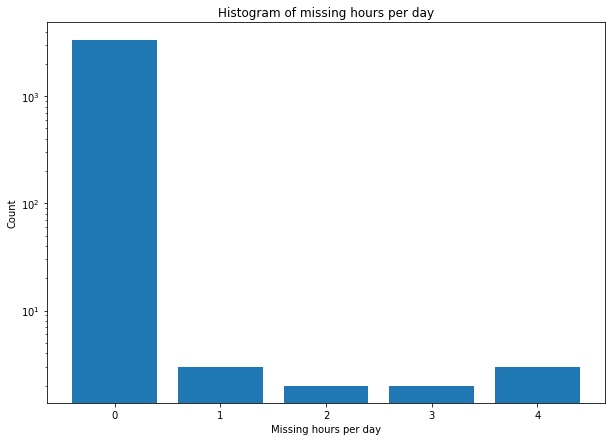

In [7]:
fig, ax = plt.subplots(figsize=(10,7))
ax.bar(bins[:-1], count)
ax.set_yscale('log')
ax.set_xlabel('Missing hours per day')
ax.set_ylabel('Count')
ax.set_title('Histogram of missing hours per day')
plt.show()

In [8]:
missing_hours_per_day_df = pd.DataFrame(missing_hours_per_day)
missing_hours_per_day_df.index = pd.to_datetime(missing_hours_per_day_df.index)
missing_hours_per_day_df.columns = ['missing_hours']
missing_hours_per_day_df = missing_hours_per_day_df.resample('1H').pad()
df_sign_missing = df_sign.join(missing_hours_per_day_df,how='inner')

df_sign_missing = df_sign_missing[df_sign_missing.missing_hours == 0]

df_sign = df_sign_missing.drop('missing_hours', axis=1)

In [9]:
df_sign.to_csv(os.path.join(DATA_CLEAN_DIR, 'acnn_sign.csv.gz'), compression='gzip')

## 2 Stylized facts

### 2.1 Log-returns

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f759459cd68>,
      dtype=object)

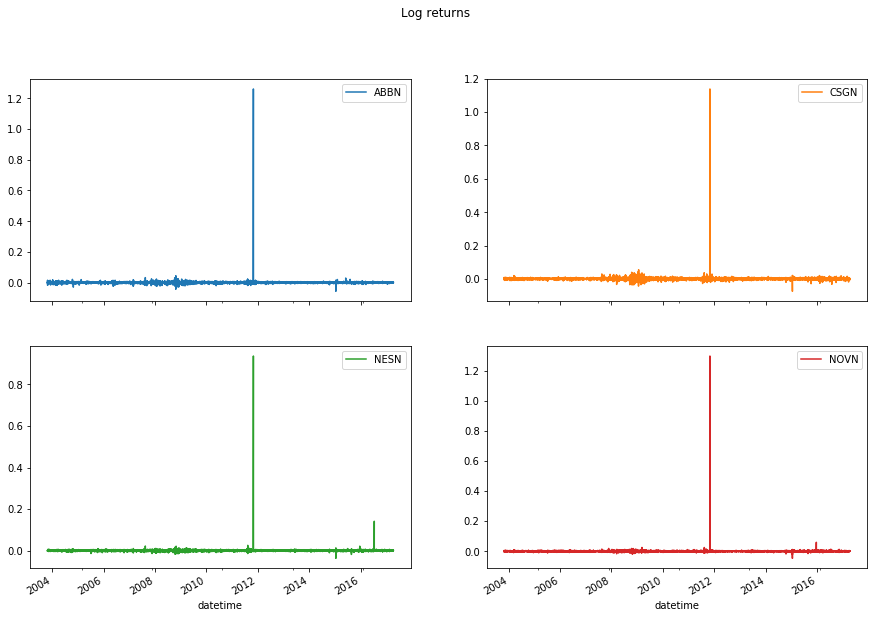

In [34]:
cleaned_df.plot(subplots=True, layout=(2,2), figsize=(15,10), title='Log returns')

There is one heavy outlier in late 2011. Just for this plot, we will remove it.
For the sign this outlier has no impact so we will not remove it from that.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7594f71208>,
      dtype=object)

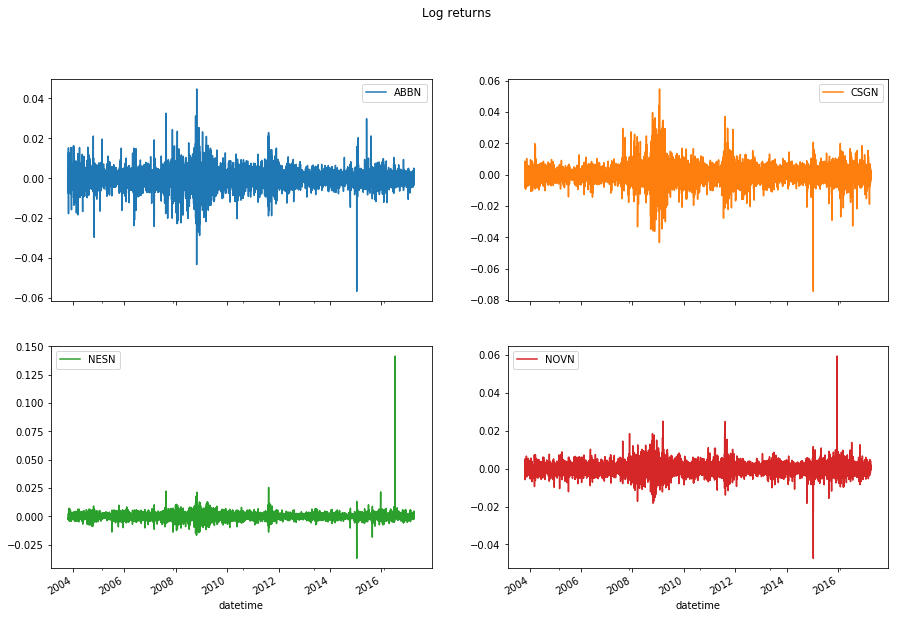

In [35]:
cleaned_df = cleaned_df[cleaned_df < 0.3].dropna()
cleaned_df.plot(subplots=True, layout=(2,2), figsize=(15,10), title='Log returns')

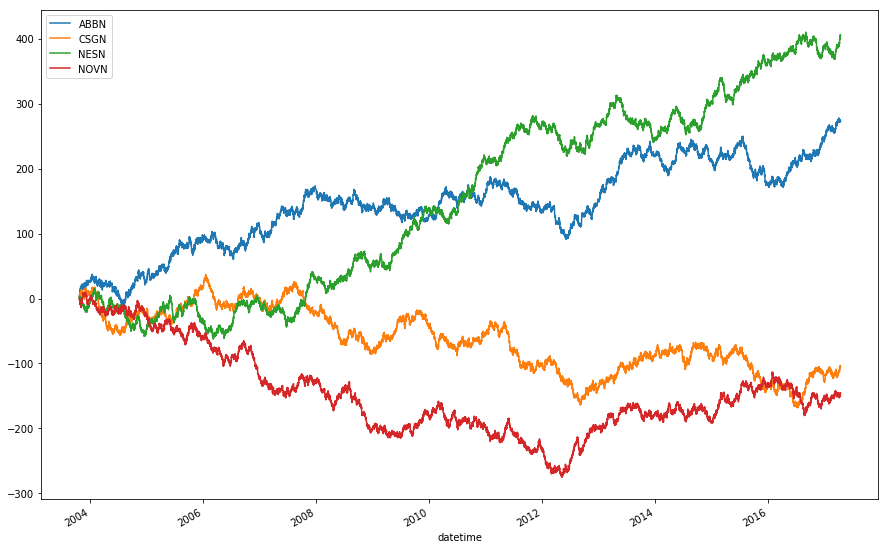

In [36]:
np.sign(cleaned_df).cumsum().plot(figsize=(15,10))

### 2.2 Autocorrelation $C_r(\tau)$

Text(0.5, 1.0, 'NOVN')

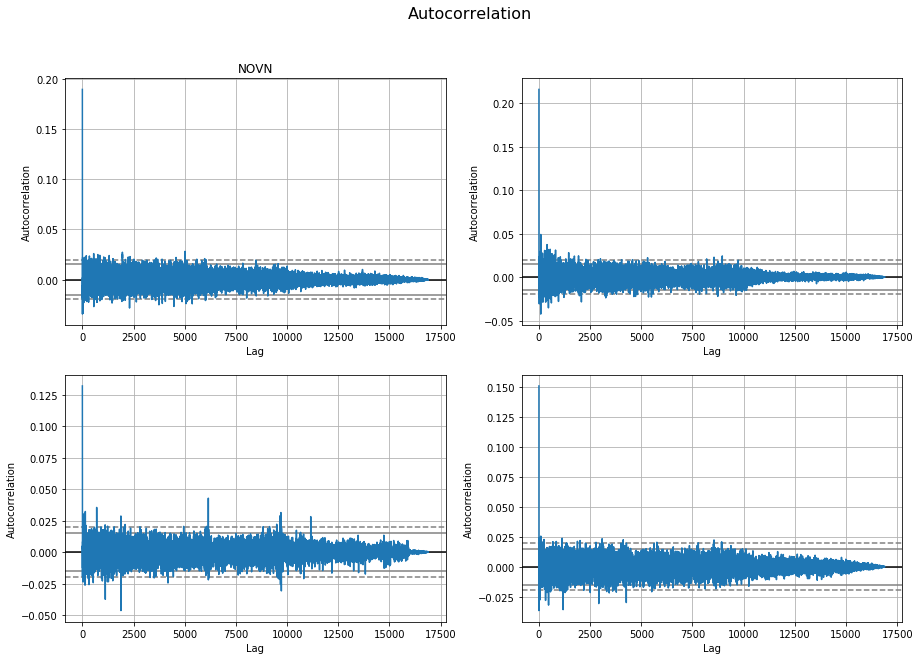

In [37]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
fig.suptitle('Autocorrelation', fontsize=16)

pd.plotting.autocorrelation_plot(cleaned_df['ABBN'], ax=ax[0,0])
ax[0,0].set_title('ABBN')
pd.plotting.autocorrelation_plot(cleaned_df['CSGN'], ax=ax[0,1])
ax[0,0].set_title('CSGN')
pd.plotting.autocorrelation_plot(cleaned_df['NESN'], ax=ax[1,0])
ax[0,0].set_title('NESN')
pd.plotting.autocorrelation_plot(cleaned_df['NOVN'], ax=ax[1,1])
ax[0,0].set_title('NOVN')

### 2.3 Plotting 1 minus ECDF

- Heavy tails or not? -> lecture 3, pages 10+, 20

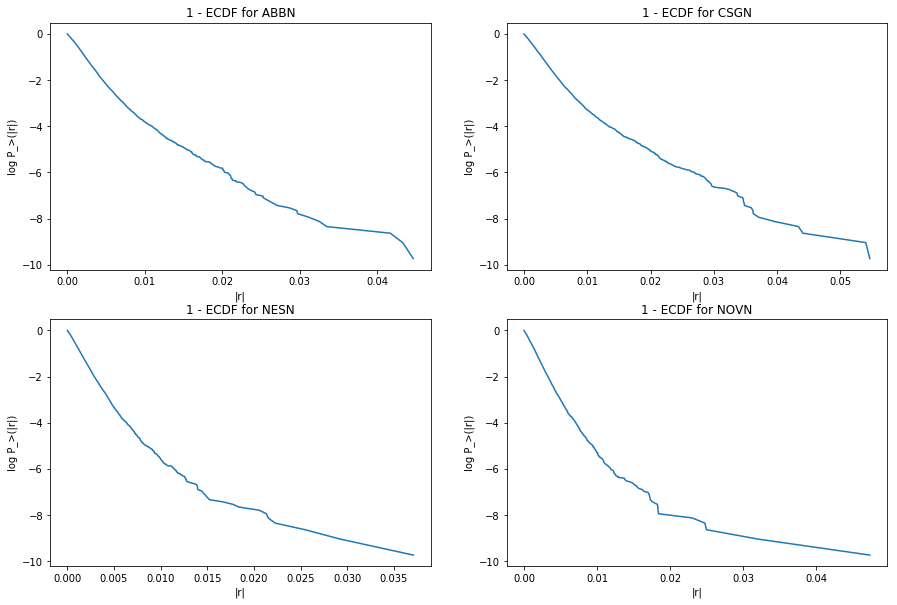

In [38]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
plot_1ecdf(cleaned_df, 'ABBN', ax=ax[0,0])
plot_1ecdf(cleaned_df, 'CSGN', ax=ax[0,1])
plot_1ecdf(cleaned_df, 'NESN', ax=ax[1,0])
plot_1ecdf(cleaned_df, 'NOVN', ax=ax[1,1])

## 3 Forecasting Example

In this section we show the whole forecasting pipeline for one example period.
We train a LSTM network using data from the past 150 days, cut into 5 day windows (25 data points).
From each window we train the network to predict the last data point using the 24 previous ones.
To generate our training data, we shift this window by one day at a time over the whole training period.
We do this for all four stocks and train the network on a random shuffle of all collected training samples.

### 3.1 Training the model

In [44]:
window_days = 5 # Number of days the LSTM sees at once
window_size = window_days * 5
step_size = 1 # Time shift for collecting training samples

start_date_train = pd.to_datetime('2013-04-05')
end_date_train = start_date_train + datetime.timedelta(days=150)

To facilitate data loading, we create a data set containing all training inputs and outputs and feed it to a data loader giving us an efficient way of handing samples to the GPU.

In [45]:
batch_size = 32
train_dataset = StockDataSet(df_sign.loc[start_date_train:end_date_train], window_size=window_size, step_size=step_size)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, drop_last=True, pin_memory=True)

Now we set up the LSTM model, the loss and optimizers and train it over 500 epochs.

In [46]:
model = LSTM_Model(1, hidden_size=64, num_layers=1, dropout=0)
criterion = torch.nn.MSELoss() #torch.nn.CrossEntropyLoss()
learning_rate = 5e-3
weight_decay = 1e-3 # L2 regularizer parameter
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

if torch.cuda.is_available():
    model.cuda()
    criterion.cuda()

In [47]:
%%time

num_epochs = 300

losses = []

for epoch in range(num_epochs):
    if (epoch+1) % 50 == 0:
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
    epoch_losses = []
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        
        hidden = model.init_hidden(batch_size)
        inputs = inputs.reshape(batch_size, window_size-1, 1).float().to(device)
        labels = labels.to(device)
        
        # Forward pass
        preds = model(inputs, hidden)

        loss = criterion(preds, labels.reshape(-1,1).float())
        #losses.append(loss.item())
        epoch_losses.append(loss.item())
        
        # Backward pass
        loss.backward()
        optimizer.step()
    losses.append(np.array(epoch_losses).mean())

Epoch 50/300
Epoch 100/300
Epoch 150/300
Epoch 200/300
Epoch 250/300
Epoch 300/300
CPU times: user 1min 41s, sys: 1min 29s, total: 3min 10s
Wall time: 3min 16s


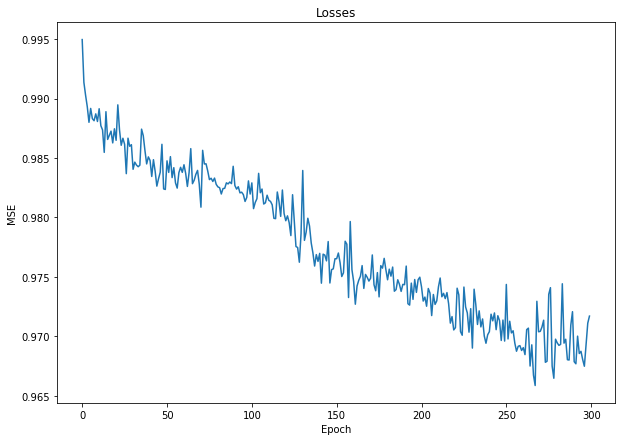

In [48]:
plot_losses(losses)

### 3.2 Prediction on test data

Prediction is done on the unseen test set starting right after the train set. 
We feed the network the first 5 days (24 data points) of the test set and predict the sign of the 25th point. 
This prediction is then appended to the known window and taken as input to the network.
We do this for 5 days into the future.

In [49]:
num_values_to_predict = 25
test_window = df_sign.loc[end_date_train:].iloc[:window_size-1+num_values_to_predict]

In [50]:
def predict_stock(test_window, model, stock_name, window_size, num_values_to_predict):
    input_test = test_window[stock_name].iloc[:window_size-1].values
    input_test = torch.Tensor(input_test).reshape(1,-1,1)
    
    predictions = []
    for i in range(num_values_to_predict):
        hidden = model.init_hidden(1)
        pred = model(input_test, hidden)[0][0].detach().cpu().numpy()
        pred_sign = np.sign(pred)
        predictions.append(int(pred_sign))
        input_test = torch.cat([input_test, torch.Tensor([pred_sign]).reshape(1,1,1).float()], dim=1)[:,1:,:]
    predictions = np.array(predictions)
    
    pred_indices = test_window.index[window_size-1:]
    return pd.Series(predictions, index=pred_indices).rename(stock_name + '_pred')

In [51]:
preds = []
for stock_name in ['ABBN', 'CSGN', 'NESN', 'NOVN']:
    preds.append(predict_stock(test_window, model, stock_name, 25, 25))
preds = pd.DataFrame(preds).transpose()

To be able to visualize our predictions nicely, we decided to compute the cumulative sum of our sign predictions.
Like that we can observe the trend in a cumulative fashion and compare it with the true data.

In [52]:
test_cumsum = test_window.join(preds).cumsum()
last_values = test_cumsum.iloc[window_size-2]
for stock_name in ['ABBN', 'CSGN', 'NESN', 'NOVN']:
    test_cumsum[stock_name + '_pred'] = test_cumsum[stock_name + '_pred'] + last_values[stock_name]

Text(0.5, 0.98, 'Cumulative sum of signs')

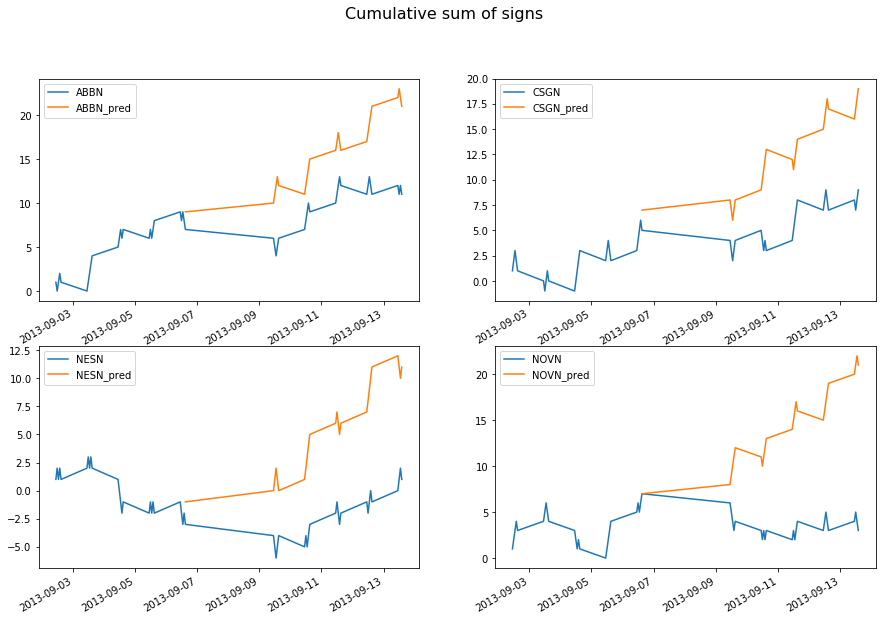

In [53]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
test_cumsum[['ABBN', 'ABBN_pred']].plot(ax=ax[0,0])
test_cumsum[['CSGN', 'CSGN_pred']].plot(ax=ax[0,1])
test_cumsum[['NESN', 'NESN_pred']].plot(ax=ax[1,0])
test_cumsum[['NOVN', 'NOVN_pred']].plot(ax=ax[1,1])
fig.suptitle('Cumulative sum of signs', fontsize=16)

## 4 Sliding window prediction

We would like to have a rolling window over the data. Our training window is always 150 days, while the test window is 5 days for the initial data points plus 5 days that we predict.
We would always slide the window forward by 5 days and train again.

For one year we need to train a network (365 - 150 - 5) / 5 = 42 times. 
From our previous section, we saw that training one window takes roughly 4.5 minutes on a Nvidia GTX 970 graphics card.
Training 42 times will take 42 * 4.5min = 189min = 3.15h.
Because with our dataset we have whole years from 2004 to 2013, we decided to train our method only on the evenly spaced years 2004, 2008, 2012 and 2016. Because those years are all leap years, we have 3

In [54]:
def sliding_predictions(df, train_samples=500, window_size=25):
    batch_size = 32
    num_samples = len(df)
    print('Total samples: {}'.format(num_samples))
    
    all_preds = pd.DataFrame()
    all_cumsum = pd.DataFrame()
    
    # First sliding window start and end indices
    start_idx_train = 0
    end_idx_train   = start_idx_train + train_samples
    start_idx_test  = end_idx_train
    end_idx_test    = start_idx_test + (2*window_size)
    
    # Do the train / test loop for every sliding window
    while end_idx_test <= num_samples-1:
        print('Window incides -> Train: {}-{}, Test: {}-{}'.format(start_idx_train, end_idx_train, start_idx_test, end_idx_test))
        
        # Define the train window and create a data loader
        train_df = df.iloc[start_idx_train:end_idx_train]
        train_dataset = StockDataSet(train_df, window_size=window_size, step_size=1)
        train_loader  = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, drop_last=True, pin_memory=True)
        
        # Initialize the model
        model = LSTM_Model(1, hidden_size=64, num_layers=1, dropout=0)
        criterion = torch.nn.MSELoss()
        learning_rate = 5e-3
        weight_decay = 1e-3 # L2 regularizer parameter
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        if torch.cuda.is_available():
            model.cuda()
            criterion.cuda()

        # Train the model
        
        num_epochs = 500
        for epoch in range(num_epochs):
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                hidden = model.init_hidden(batch_size)
                inputs = inputs.reshape(batch_size, window_size-1, 1).float().to(device)
                labels = labels.to(device)
                # Forward pass
                preds = model(inputs, hidden)
                loss = criterion(preds, labels.reshape(-1,1).float())
                # Backward pass
                loss.backward()
                optimizer.step()
                
        # Predict values
        test_df = df.iloc[start_idx_test:end_idx_test-1]
        preds = []
        for stock_name in ['ABBN', 'CSGN', 'NESN', 'NOVN']:
            preds.append(predict_stock(test_df, model, stock_name, window_size, window_size))
        preds = pd.DataFrame(preds).transpose()
        all_preds = pd.concat([all_preds, preds])
        all_cumsum = pd.concat([all_cumsum, preds.cumsum()])
                
        # Shift sliding window forward
        start_idx_train = start_idx_train + window_size
        end_idx_train   = start_idx_train + train_samples
        start_idx_test  = end_idx_train
        end_idx_test    = start_idx_test + (2*window_size)
        
    return all_preds, all_cumsum

In [55]:
def plot_rolling_window(df_sign, year, train_samples=500, window_size=25):
    stocks = ['ABBN', 'CSGN', 'NESN', 'NOVN']
    stocks_pred = ['ABBN_pred', 'CSGN_pred', 'NESN_pred', 'NOVN_pred']
    
    start_date = pd.to_datetime('{}-01-01'.format(year))
    end_date = start_date + datetime.timedelta(days=366)
    df = df_sign.copy().loc[start_date:end_date]
    
    preds, cumsum_preds = sliding_predictions(df, train_samples=train_samples, window_size=window_size)
    
    preds.to_csv(os.path.join(DATA_CLEAN_DIR, 'preds_{}.csv.gz'.format(year)), compression='gzip')
    cumsum_preds.to_csv(os.path.join(DATA_CLEAN_DIR, 'cumsum_preds_{}.csv.gz'.format(year)), compression='gzip')
    
    cumsum_df = df.join(cumsum_preds).iloc[train_samples:]
    cumsum_df[stocks] = cumsum_df[stocks].cumsum()
    plot_cumsums(cumsum_df, year, window_size)

### 4.1 2004-2005

Total samples: 1245
Window incides -> Train: 0-500, Test: 500-550
Window incides -> Train: 25-525, Test: 525-575
Window incides -> Train: 50-550, Test: 550-600
Window incides -> Train: 75-575, Test: 575-625
Window incides -> Train: 100-600, Test: 600-650
Window incides -> Train: 125-625, Test: 625-675
Window incides -> Train: 150-650, Test: 650-700
Window incides -> Train: 175-675, Test: 675-725
Window incides -> Train: 200-700, Test: 700-750
Window incides -> Train: 225-725, Test: 725-775
Window incides -> Train: 250-750, Test: 750-800
Window incides -> Train: 275-775, Test: 775-825
Window incides -> Train: 300-800, Test: 800-850
Window incides -> Train: 325-825, Test: 825-875
Window incides -> Train: 350-850, Test: 850-900
Window incides -> Train: 375-875, Test: 875-925
Window incides -> Train: 400-900, Test: 900-950
Window incides -> Train: 425-925, Test: 925-975
Window incides -> Train: 450-950, Test: 950-1000
Window incides -> Train: 475-975, Test: 975-1025
Window incides -> Train

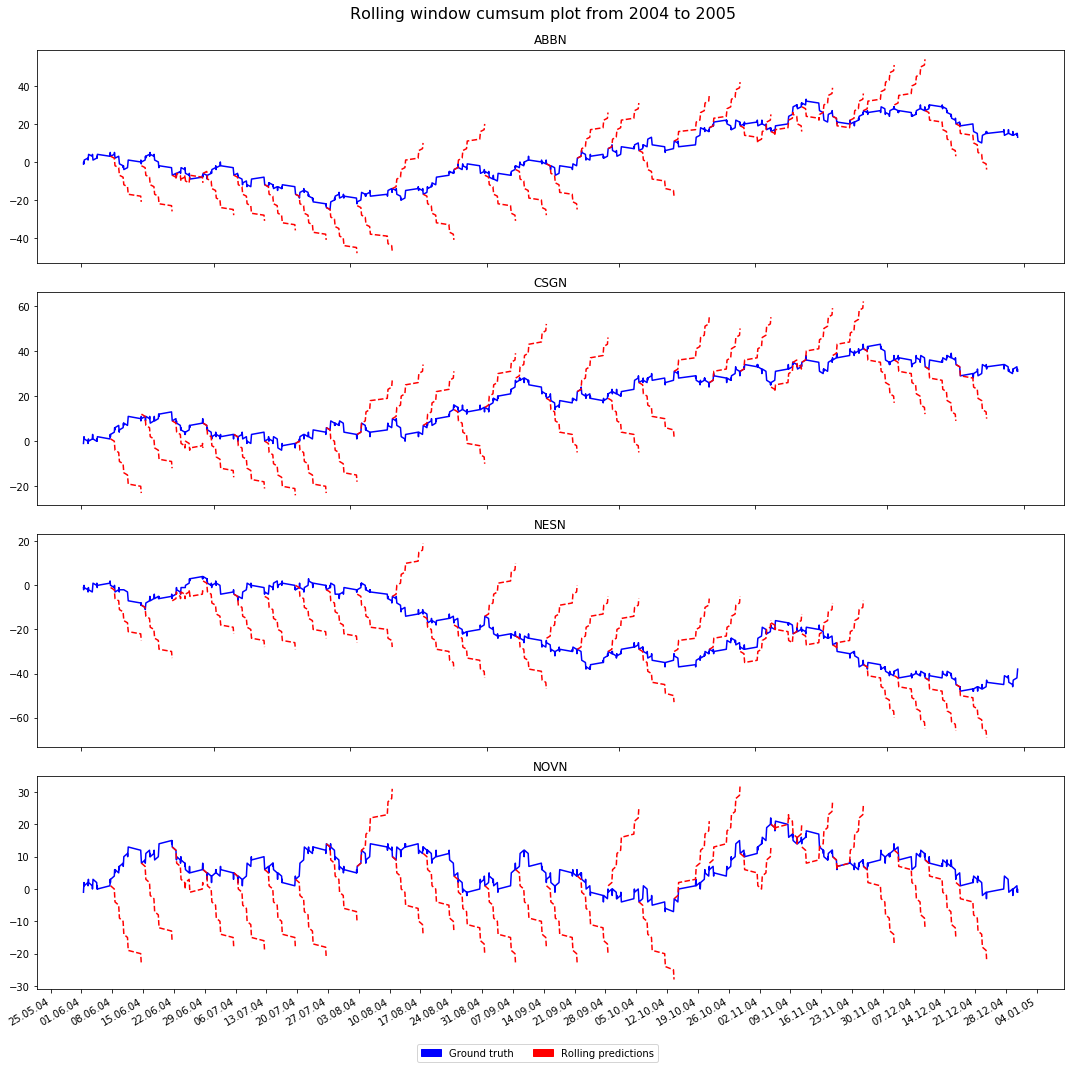

In [56]:
plot_rolling_window(df_sign, 2004)

### 4.1 2008-2009

Total samples: 1240
Window incides -> Train: 0-500, Test: 500-550
Window incides -> Train: 25-525, Test: 525-575
Window incides -> Train: 50-550, Test: 550-600
Window incides -> Train: 75-575, Test: 575-625
Window incides -> Train: 100-600, Test: 600-650
Window incides -> Train: 125-625, Test: 625-675
Window incides -> Train: 150-650, Test: 650-700
Window incides -> Train: 175-675, Test: 675-725
Window incides -> Train: 200-700, Test: 700-750
Window incides -> Train: 225-725, Test: 725-775
Window incides -> Train: 250-750, Test: 750-800
Window incides -> Train: 275-775, Test: 775-825
Window incides -> Train: 300-800, Test: 800-850
Window incides -> Train: 325-825, Test: 825-875
Window incides -> Train: 350-850, Test: 850-900
Window incides -> Train: 375-875, Test: 875-925
Window incides -> Train: 400-900, Test: 900-950
Window incides -> Train: 425-925, Test: 925-975
Window incides -> Train: 450-950, Test: 950-1000
Window incides -> Train: 475-975, Test: 975-1025
Window incides -> Train

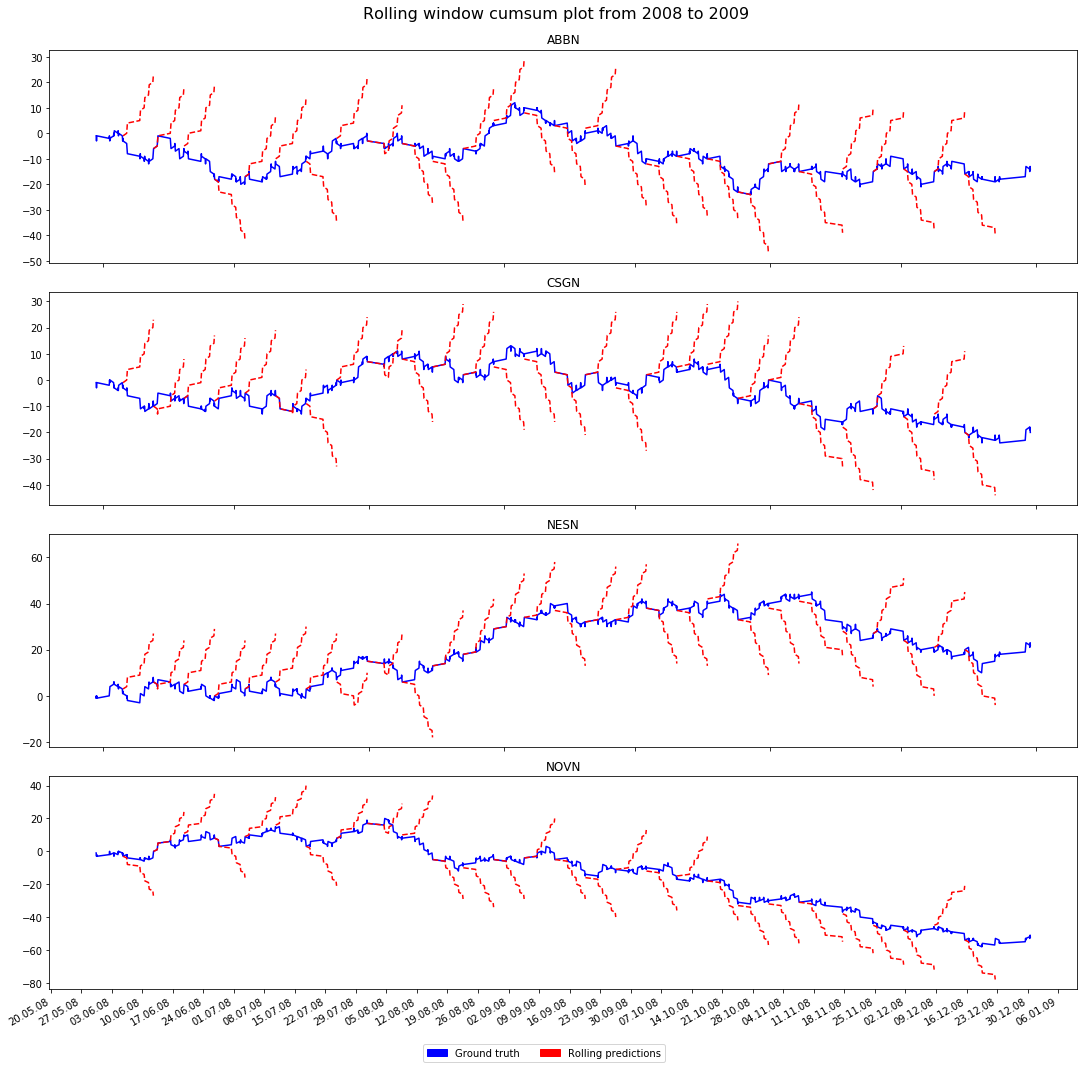

In [57]:
plot_rolling_window(df_sign, 2008)

### 4.1 2012-2013

Total samples: 1245
Window incides -> Train: 0-500, Test: 500-550
Window incides -> Train: 25-525, Test: 525-575
Window incides -> Train: 50-550, Test: 550-600
Window incides -> Train: 75-575, Test: 575-625
Window incides -> Train: 100-600, Test: 600-650
Window incides -> Train: 125-625, Test: 625-675
Window incides -> Train: 150-650, Test: 650-700
Window incides -> Train: 175-675, Test: 675-725
Window incides -> Train: 200-700, Test: 700-750
Window incides -> Train: 225-725, Test: 725-775
Window incides -> Train: 250-750, Test: 750-800
Window incides -> Train: 275-775, Test: 775-825
Window incides -> Train: 300-800, Test: 800-850
Window incides -> Train: 325-825, Test: 825-875
Window incides -> Train: 350-850, Test: 850-900
Window incides -> Train: 375-875, Test: 875-925
Window incides -> Train: 400-900, Test: 900-950
Window incides -> Train: 425-925, Test: 925-975
Window incides -> Train: 450-950, Test: 950-1000
Window incides -> Train: 475-975, Test: 975-1025
Window incides -> Train

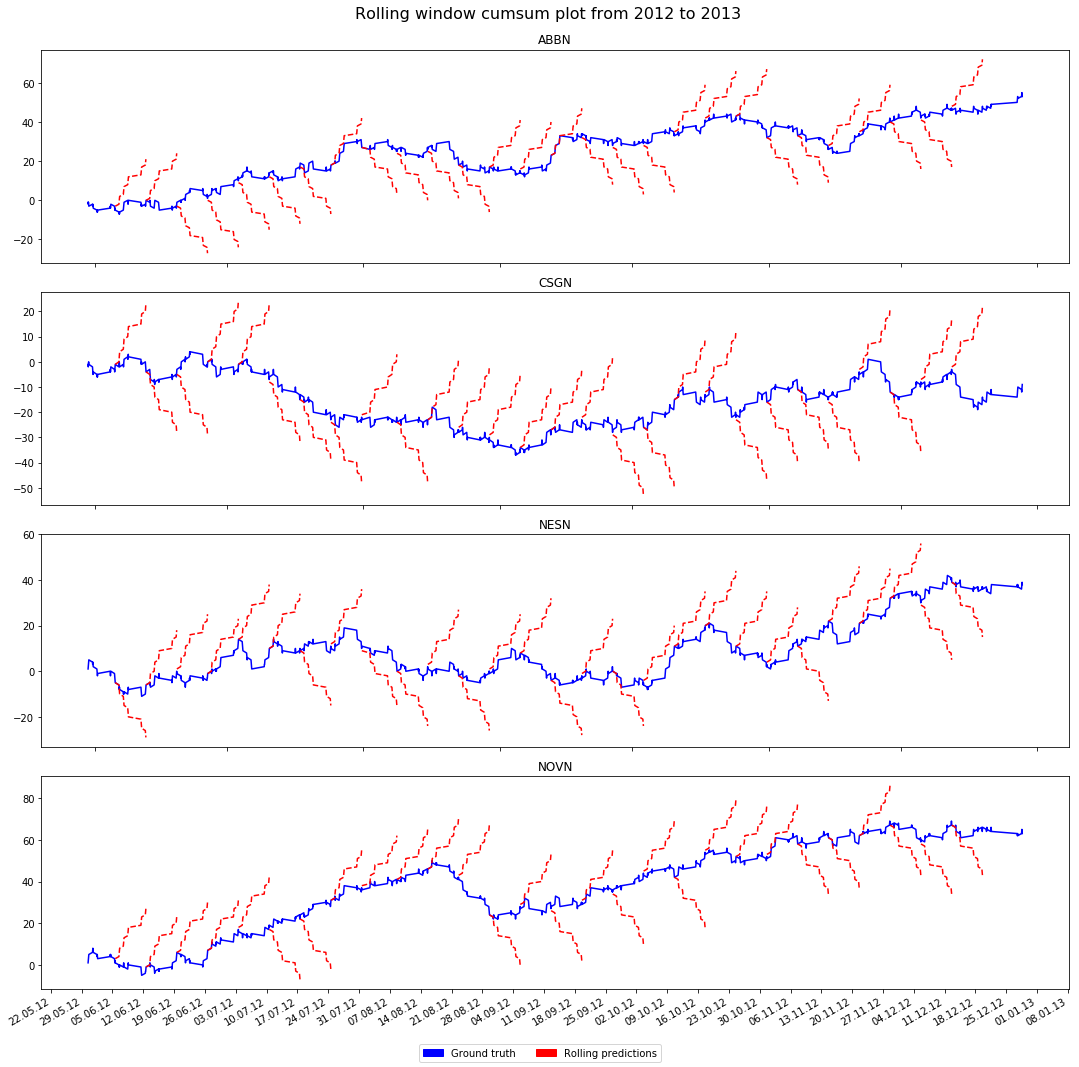

In [58]:
plot_rolling_window(df_sign, 2012)

### 4.1 2016-2017

Total samples: 1270
Window incides -> Train: 0-500, Test: 500-550
Window incides -> Train: 25-525, Test: 525-575
Window incides -> Train: 50-550, Test: 550-600
Window incides -> Train: 75-575, Test: 575-625
Window incides -> Train: 100-600, Test: 600-650
Window incides -> Train: 125-625, Test: 625-675
Window incides -> Train: 150-650, Test: 650-700
Window incides -> Train: 175-675, Test: 675-725
Window incides -> Train: 200-700, Test: 700-750
Window incides -> Train: 225-725, Test: 725-775
Window incides -> Train: 250-750, Test: 750-800
Window incides -> Train: 275-775, Test: 775-825
Window incides -> Train: 300-800, Test: 800-850
Window incides -> Train: 325-825, Test: 825-875
Window incides -> Train: 350-850, Test: 850-900
Window incides -> Train: 375-875, Test: 875-925
Window incides -> Train: 400-900, Test: 900-950
Window incides -> Train: 425-925, Test: 925-975
Window incides -> Train: 450-950, Test: 950-1000
Window incides -> Train: 475-975, Test: 975-1025
Window incides -> Train

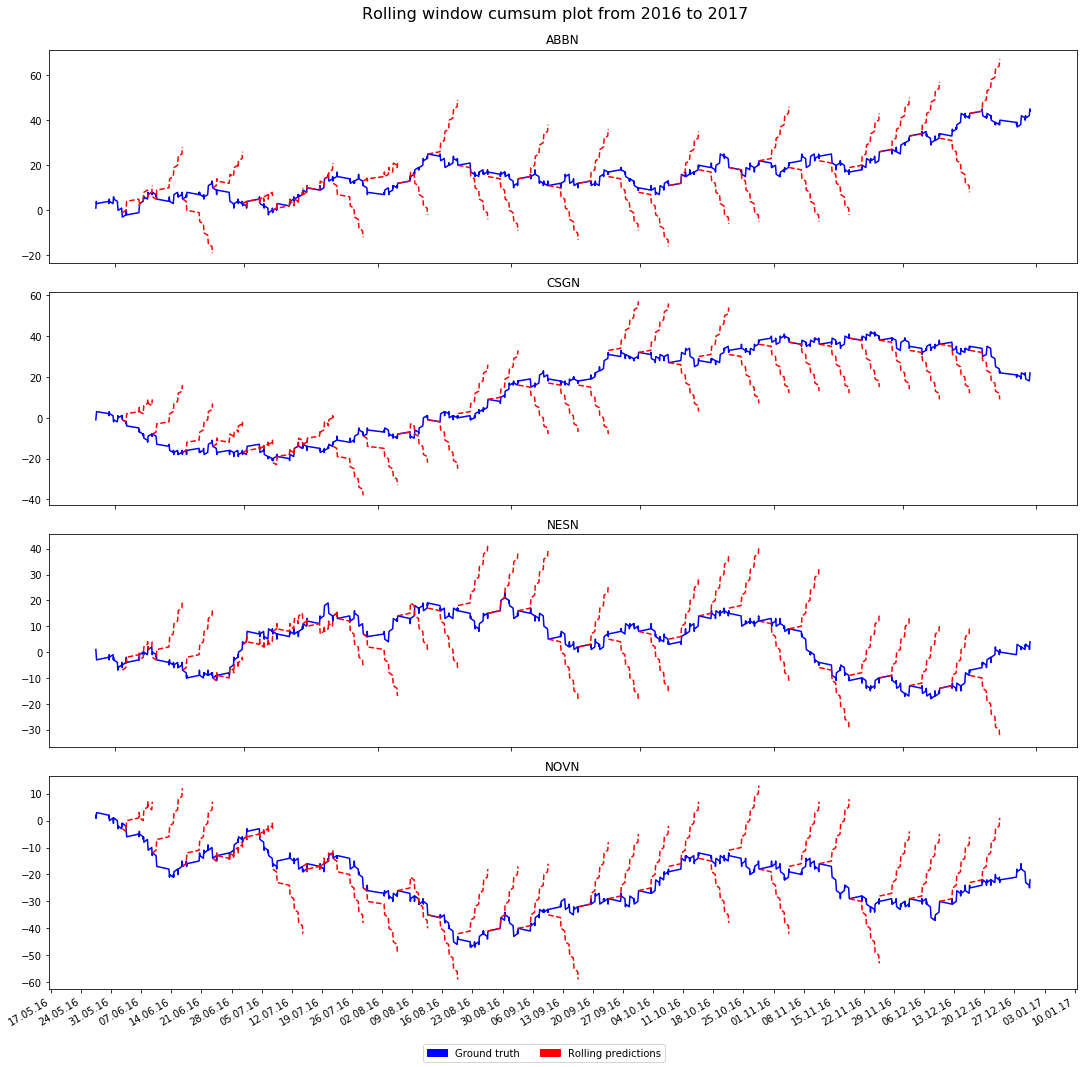

In [59]:
plot_rolling_window(df_sign, 2016)

## 5 Evaluation

### 5.1 

In [60]:
preds2004 = pd.read_csv(os.path.join(DATA_CLEAN_DIR, 'preds_2004.csv.gz'), compression='gzip')

In [61]:
preds2004

,Unnamed: 0,ABBN_pred,CSGN_pred,NESN_pred,NOVN_pred
0,2004-06-07 15:00:00,-1,-1,-1,-1
1,2004-06-08 11:00:00,-1,-1,-1,-1
2,2004-06-08 12:00:00,-1,-1,-1,-1
3,2004-06-08 13:00:00,-1,-1,-1,-1
4,2004-06-08 14:00:00,-1,-1,-1,-1
5,2004-06-08 15:00:00,-1,-1,-1,-1
6,2004-06-09 11:00:00,-1,-1,-1,-1
7,2004-06-09 12:00:00,-1,-1,-1,-1
8,2004-06-09 13:00:00,-1,-1,-1,-1
9,2004-06-09 14:00:00,-1,-1,-1,-1
